# BERT Cased with Interweaving Fine-Tuned Approach on Disability and Religion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.3 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERT Cased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained BERT Cased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertcased model instance
    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Religion

In [6]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Religion
religion_train_df, religion_val_df, religion_test_df = load_data('religion')
X_religion_train, y_religion_train, X_religion_test, y_religion_test, X_religion_val, y_religion_val = load_data_as_arr(religion_train_df, religion_val_df, religion_test_df)

In [7]:
X_disability_train[1]

' mental disability is extremely physical'

In [8]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [9]:
len(X_disability_train)

24904

In [10]:
X_religion_train[0]

' Martin Luther King Jr. and Malcolm X were both killed by violent extremists'

In [11]:
len(X_religion_train)

14811

## Load BERT Cased Model from_pretrained()

In [12]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [14]:
# Disability
bertcased_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertcased_tokenizer)
bertcased_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertcased_tokenizer)
bertcased_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertcased_tokenizer)

# Religion
bertcased_religion_train_inputs = tokenizing_pipeline(X_religion_train, bertcased_tokenizer)
bertcased_religion_test_inputs = tokenizing_pipeline(X_religion_test, bertcased_tokenizer)
bertcased_religion_val_inputs = tokenizing_pipeline(X_religion_val, bertcased_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [15]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for religon train set:

In [16]:
neg, pos = np.bincount(y_religion_train)
total = neg + pos
print('Religion Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

religion_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Religion Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Religion Train Weight for class 1: {:.2f}'.format(weight_for_1))

Religion Train Examples:
    Total: 14811
    Positive: 7560 (51.04% of total)

Religion Train Weight for class 0: 1.02
Religion Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [17]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [18]:
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Religion Model

In [19]:
religion_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
religion_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Gender Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [20]:
disability_round1_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 96s 76ms/step - loss: 0.6086 - binary_accuracy: 0.6607 - precision: 0.6761 - recall: 0.6728 - f1_score: 0.6744 - val_loss: 0.5059 - val_binary_accuracy: 0.7577 - val_precision: 0.7863 - val_recall: 0.7315 - val_f1_score: 0.7579


## Round 2: Train Religion Model for 1 epoch

In [21]:
religion_round2_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 66s 82ms/step - loss: 0.6191 - binary_accuracy: 0.6594 - precision_1: 0.6480 - recall_1: 0.7286 - f1_score: 0.6859 - val_loss: 0.4913 - val_binary_accuracy: 0.7789 - val_precision_1: 0.8014 - val_recall_1: 0.7693 - val_f1_score: 0.7850


## Round 3: Train Disability Model for 1 epoch

In [22]:
disability_round3_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4916 - binary_accuracy: 0.7672 - precision: 0.7820 - recall: 0.7686 - f1_score: 0.7752 - val_loss: 0.4635 - val_binary_accuracy: 0.7765 - val_precision: 0.7888 - val_recall: 0.7771 - val_f1_score: 0.7829


## Round 4: Train Religion Model on for 1 epoch

In [23]:
religion_round4_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 76ms/step - loss: 0.4733 - binary_accuracy: 0.7825 - precision_1: 0.7900 - recall_1: 0.7817 - f1_score: 0.7859 - val_loss: 0.4427 - val_binary_accuracy: 0.7951 - val_precision_1: 0.8359 - val_recall_1: 0.7585 - val_f1_score: 0.7953


## Round 5: Train Disability Model for 1 epoch

In [24]:
disability_round5_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4605 - binary_accuracy: 0.7861 - precision: 0.8059 - recall: 0.7778 - f1_score: 0.7916 - val_loss: 0.4462 - val_binary_accuracy: 0.7864 - val_precision: 0.8046 - val_recall: 0.7766 - val_f1_score: 0.7904


### Checkpoint #1: Save Disability Model Weights for Round 5

In [25]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_disability-checkpt1-round_5.hdf5')

## Round 6: Train Religion Model for 1 epoch

In [26]:
religion_round6_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 77ms/step - loss: 0.4382 - binary_accuracy: 0.7980 - precision_1: 0.8104 - recall_1: 0.7888 - f1_score: 0.7994 - val_loss: 0.4202 - val_binary_accuracy: 0.8048 - val_precision_1: 0.8336 - val_recall_1: 0.7847 - val_f1_score: 0.8084



## Round 7: Train Disability Model for 1 epoch

In [27]:
disability_round7_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4434 - binary_accuracy: 0.7926 - precision: 0.8128 - recall: 0.7835 - f1_score: 0.7979 - val_loss: 0.4350 - val_binary_accuracy: 0.7921 - val_precision: 0.8212 - val_recall: 0.7659 - val_f1_score: 0.7926


### Checkpoint #2: Save Disability Model Weights for Round 7

In [28]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_disability-checkpt2-round_7.hdf5')

## Round 8: Train Religion Model for 1 epoch

In [29]:
religion_round8_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 77ms/step - loss: 0.4196 - binary_accuracy: 0.8086 - precision_1: 0.8224 - recall_1: 0.7971 - f1_score: 0.8096 - val_loss: 0.4047 - val_binary_accuracy: 0.8145 - val_precision_1: 0.8407 - val_recall_1: 0.7978 - val_f1_score: 0.8187


## Round 9: Train Disability Model for 1 epoch

In [30]:
disability_round9_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4282 - binary_accuracy: 0.8042 - precision: 0.8276 - recall: 0.7898 - f1_score: 0.8083 - val_loss: 0.4268 - val_binary_accuracy: 0.7958 - val_precision: 0.8121 - val_recall: 0.7887 - val_f1_score: 0.8002


## Round 10: Train Religion Model for 1 epoch

In [31]:
religion_round10_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 77ms/step - loss: 0.4019 - binary_accuracy: 0.8215 - precision_1: 0.8334 - recall_1: 0.8127 - f1_score: 0.8229 - val_loss: 0.3912 - val_binary_accuracy: 0.8202 - val_precision_1: 0.8360 - val_recall_1: 0.8179 - val_f1_score: 0.8268


## Round 11: Train Disability Model for 1 epoch

In [32]:
disability_round11_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4157 - binary_accuracy: 0.8081 - precision: 0.8295 - recall: 0.7963 - f1_score: 0.8126 - val_loss: 0.4209 - val_binary_accuracy: 0.8037 - val_precision: 0.8192 - val_recall: 0.7975 - val_f1_score: 0.8082


## Round 12: Train Religion Model for 1 epoch

In [33]:
religion_round12_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 76ms/step - loss: 0.3861 - binary_accuracy: 0.8286 - precision_1: 0.8390 - recall_1: 0.8218 - f1_score: 0.8303 - val_loss: 0.3871 - val_binary_accuracy: 0.8230 - val_precision_1: 0.8495 - val_recall_1: 0.8056 - val_f1_score: 0.8269


### Checkpoint #3: Save Gender Model Weights for Round 12

In [34]:
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_religion-checkpt3-round_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [35]:
disability_round13_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4089 - binary_accuracy: 0.8117 - precision: 0.8351 - recall: 0.7970 - f1_score: 0.8156 - val_loss: 0.4141 - val_binary_accuracy: 0.8056 - val_precision: 0.8187 - val_recall: 0.8031 - val_f1_score: 0.8108


## Round 14: Train Religion Model on for 1 epoch

In [36]:
religion_round14_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 77ms/step - loss: 0.3793 - binary_accuracy: 0.8286 - precision_1: 0.8426 - recall_1: 0.8169 - f1_score: 0.8295 - val_loss: 0.3767 - val_binary_accuracy: 0.8287 - val_precision_1: 0.8434 - val_recall_1: 0.8272 - val_f1_score: 0.8352


## Checkpoint #4: Save Gender Model Weights for Rounds 14

In [37]:
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_religion-checkpt4-round_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [38]:
disability_round15_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.3991 - binary_accuracy: 0.8187 - precision: 0.8429 - recall: 0.8024 - f1_score: 0.8222 - val_loss: 0.4129 - val_binary_accuracy: 0.8100 - val_precision: 0.8285 - val_recall: 0.7989 - val_f1_score: 0.8134


## Round 16: Train Religion Model on for 1 epoch

In [39]:
religion_round16_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 77ms/step - loss: 0.3707 - binary_accuracy: 0.8375 - precision_1: 0.8495 - recall_1: 0.8284 - f1_score: 0.8388 - val_loss: 0.3722 - val_binary_accuracy: 0.8339 - val_precision_1: 0.8505 - val_recall_1: 0.8295 - val_f1_score: 0.8398


### Checkpoint #4: Save Model Weights for Rounds 15 and 16

In [40]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_disability-checkpt4-rounds_15_16.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_religion-checkpt4-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [41]:
disability_round17_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.3899 - binary_accuracy: 0.8240 - precision: 0.8475 - recall: 0.8087 - f1_score: 0.8276 - val_loss: 0.4106 - val_binary_accuracy: 0.8105 - val_precision: 0.8237 - val_recall: 0.8072 - val_f1_score: 0.8154


## Round 18: Train Religion Model for 1 epoch

In [42]:
religion_round18_history = religion_model.fit(bertcased_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertcased_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 47s 76ms/step - loss: 0.3586 - binary_accuracy: 0.8409 - precision_1: 0.8515 - recall_1: 0.8337 - f1_score: 0.8425 - val_loss: 0.3695 - val_binary_accuracy: 0.8343 - val_precision_1: 0.8523 - val_recall_1: 0.8279 - val_f1_score: 0.8399


# Plots for Disability Model

In [43]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

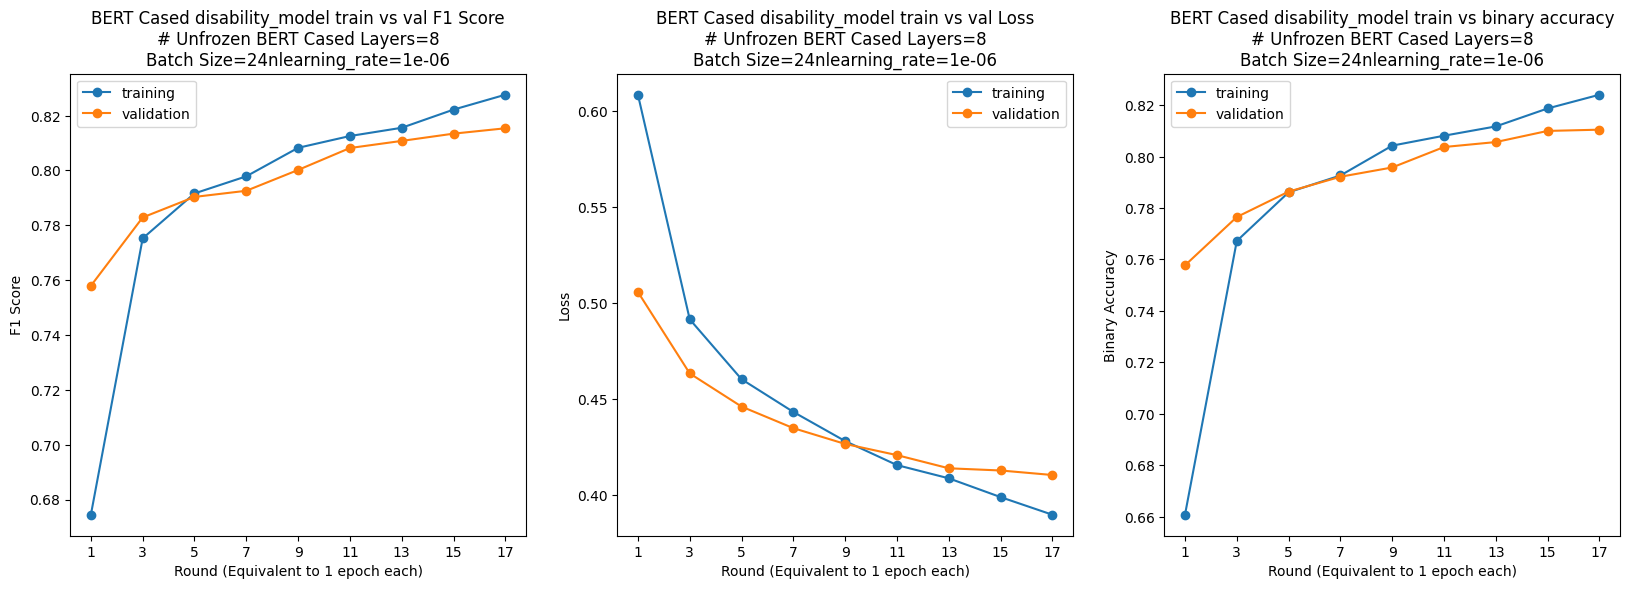

In [44]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERT Cased disability_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERT Cased disability_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERT Cased disability_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Religion Model

In [45]:
religion_train_f1_scores = [religion_round2_history.history['f1_score'][0][0],
                     religion_round4_history.history['f1_score'][0][0],
                     religion_round6_history.history['f1_score'][0][0],
                     religion_round8_history.history['f1_score'][0][0],
                     religion_round10_history.history['f1_score'][0][0],
                     religion_round12_history.history['f1_score'][0][0],
                     religion_round14_history.history['f1_score'][0][0],
                     religion_round16_history.history['f1_score'][0][0],
                     religion_round18_history.history['f1_score'][0][0]]
religion_val_f1_scores = [religion_round2_history.history['val_f1_score'][0][0],
                     religion_round4_history.history['val_f1_score'][0][0],
                     religion_round6_history.history['val_f1_score'][0][0],
                     religion_round8_history.history['val_f1_score'][0][0],
                     religion_round10_history.history['val_f1_score'][0][0],
                     religion_round12_history.history['val_f1_score'][0][0],
                     religion_round14_history.history['val_f1_score'][0][0],
                     religion_round16_history.history['val_f1_score'][0][0],
                     religion_round18_history.history['val_f1_score'][0][0]]
religion_train_loss = [religion_round2_history.history['loss'][0],
                     religion_round4_history.history['loss'][0],
                     religion_round6_history.history['loss'][0],
                     religion_round8_history.history['loss'][0],
                     religion_round10_history.history['loss'][0],
                     religion_round12_history.history['loss'][0],
                     religion_round14_history.history['loss'][0],
                     religion_round16_history.history['loss'][0],
                     religion_round18_history.history['loss'][0]]
religion_val_loss = [religion_round2_history.history['val_loss'][0],
                     religion_round4_history.history['val_loss'][0],
                     religion_round6_history.history['val_loss'][0],
                     religion_round8_history.history['val_loss'][0],
                     religion_round10_history.history['val_loss'][0],
                     religion_round12_history.history['val_loss'][0],
                     religion_round14_history.history['val_loss'][0],
                     religion_round16_history.history['val_loss'][0],
                     religion_round18_history.history['val_loss'][0]]
religion_train_binary_accuracy = [religion_round2_history.history['binary_accuracy'][0],
                     religion_round4_history.history['binary_accuracy'][0],
                     religion_round6_history.history['binary_accuracy'][0],
                     religion_round8_history.history['binary_accuracy'][0],
                     religion_round10_history.history['binary_accuracy'][0],
                     religion_round12_history.history['binary_accuracy'][0],
                     religion_round14_history.history['binary_accuracy'][0],
                     religion_round16_history.history['binary_accuracy'][0],
                     religion_round18_history.history['binary_accuracy'][0]]
religion_val_binary_accuracy = [religion_round2_history.history['val_binary_accuracy'][0],
                     religion_round4_history.history['val_binary_accuracy'][0],
                     religion_round6_history.history['val_binary_accuracy'][0],
                     religion_round8_history.history['val_binary_accuracy'][0],
                     religion_round10_history.history['val_binary_accuracy'][0],
                     religion_round12_history.history['val_binary_accuracy'][0],
                     religion_round14_history.history['val_binary_accuracy'][0],
                     religion_round16_history.history['val_binary_accuracy'][0],
                     religion_round18_history.history['val_binary_accuracy'][0]]


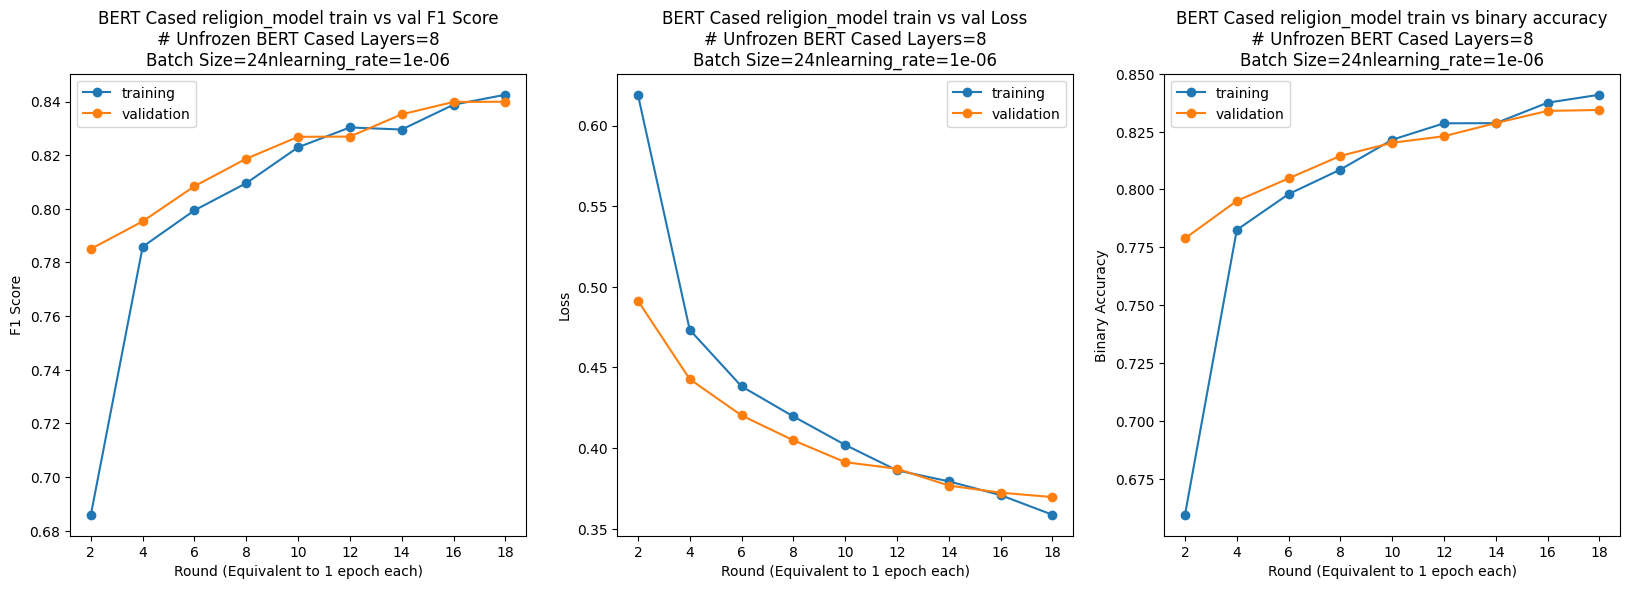

In [46]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(religion_train_f1_scores, label="training", marker='o')
axis[0].plot(religion_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERT Cased religion_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(religion_train_loss, label="training", marker='o')
axis[1].plot(religion_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERT Cased religion_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(religion_train_binary_accuracy, label="training", marker='o')
axis[2].plot(religion_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERT Cased religion_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_disability.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Religion_Interwoven_religion.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training

DISABILITY MODEL RESULTS

In [ ]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

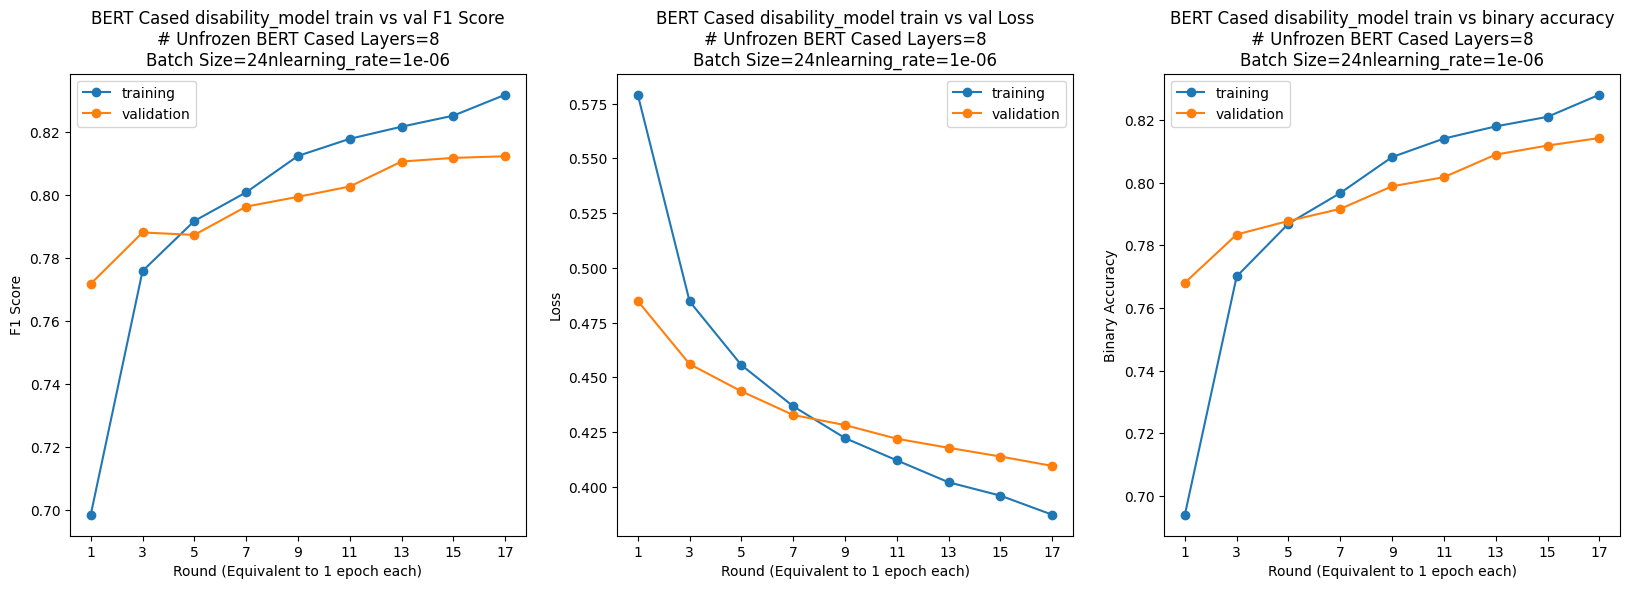

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at round 5 or 7

RELIGION MODEL RESULTS

In [ ]:
print('religion_train_f1_scores:', religion_train_f1_scores)
print('religion_val_f1_scores:', religion_val_f1_scores)
print('\nreligion_train_loss:', religion_train_loss)
print('religion_val_loss:', religion_val_loss)
print('\nreligion_train_binary_accuracy:', religion_train_binary_accuracy)
print('religion_val_binary_accuracy:', religion_val_binary_accuracy)

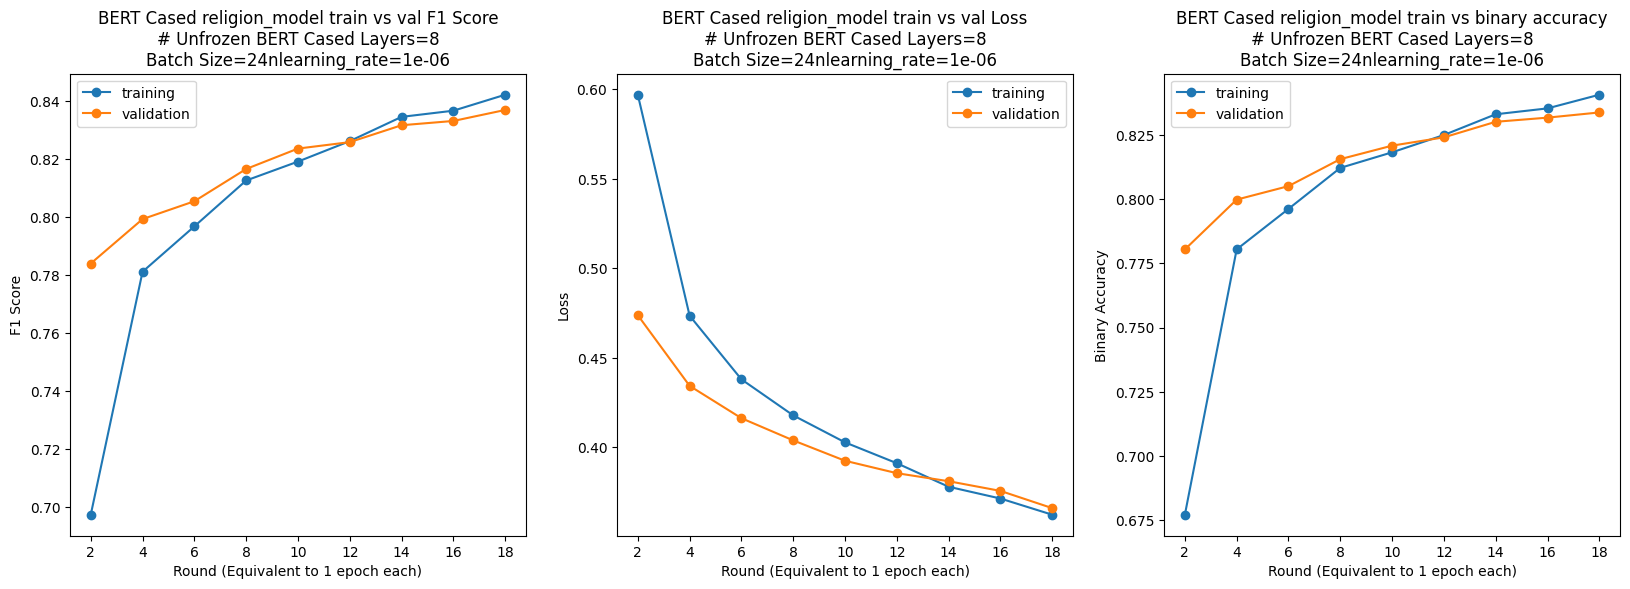

In [ ]:
# RELIGION MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the religion_model weights at round 12